## CDCS_MP

This notebook obtains and performs some image analysis on optical images taken under bright field (BF) imaging conditions from the ambench.nist.gov database.

In [1]:
import pandas as py             # a standard Python data processing library
import lxml.etree as et
from cdcs import CDCS
from urllib import request
from skimage import io

### 1. Importing records from CDCS
 - uses the CDCS REST API client to search for datasets related to the melt pool (MP) challenge within the ambench.nist.gov   instance
 - searches the returned datasets for tiff images containing the phrase "BF" and collects information about the corresponding track and case for each image
 - stores image names, image data, track, and case in a pandas dataframe

create a CDCS query instance and input a keyword

In [3]:
keyword='MP'
curator = CDCS('https://ambench.nist.gov/', username='') #accessing anonymously
df=curator.query(template='AM-Bench-2018',keyword=keyword) #searching for results with the phrase'MP'
df #display the dataframe

,id,template,workspace,user_id,title,xml_content,creation_date,last_modification_date,last_change_date,template_title
0,5fb6e83975853f003c17ea80,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR8-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:48:41.113000Z,2020-11-19T21:48:41.113000Z,2020-11-19T21:51:26.270000Z,AM-Bench-2018
1,5fb6e82875853f004017efa3,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR4-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:48:24.455000Z,2020-11-19T21:48:24.455000Z,2020-11-19T21:51:26.622000Z,AM-Bench-2018
2,5fb6e80f75853f003917ee11,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR3-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:47:59.727000Z,2020-11-19T21:47:59.727000Z,2020-11-19T21:51:27.278000Z,AM-Bench-2018
3,5fb6e7ed75853f004117ee5a,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR1-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/20...",2020-11-19T21:47:25.764000Z,2020-11-19T21:47:25.764000Z,2020-11-19T21:51:28.134000Z,AM-Bench-2018
4,5fb6e7cb75853f003617edf8,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR6-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:46:51.808000Z,2020-11-19T21:46:51.808000Z,2020-11-19T21:51:29.140000Z,AM-Bench-2018
5,5fb6e7ba75853f003f17ed54,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR10-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:46:34.543000Z,2020-11-19T21:46:34.543000Z,2020-11-19T21:51:29.466000Z,AM-Bench-2018
6,5fb6e7ae75853f004617eb2b,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR2-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/20...",2020-11-19T21:46:22.864000Z,2020-11-19T21:46:22.864000Z,2020-11-19T21:51:29.635000Z,AM-Bench-2018
7,5fb6e73675853f003d17eaf2,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR7-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:44:22.018000Z,2020-11-19T21:44:22.018000Z,2020-11-19T21:51:31.479000Z,AM-Bench-2018
8,5fb6e6ef75853f003d17ea88,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR5-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:43:11.946000Z,2020-11-19T21:43:11.946000Z,2020-11-19T21:51:32.880000Z,AM-Bench-2018
9,5fb6e6e175853f004317ea6d,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR9-MP.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:42:57.612000Z,2020-11-19T21:42:57.612000Z,2020-11-19T21:51:33.045000Z,AM-Bench-2018


#### xml_url_find:
Parameters:
- XML file for one of the ambench.nist.gov datasets in string format
- search phrase contained in the file name
- file type

Returns:
- a list containing (0) name of a file, (1) the download url for the file, (2) laser track number, (3) case 

In [4]:
def xml_url_find(xml,searchphrase,mtype):
    root=et.fromstring(xml)
    caseid=root.find('.//TraceID')[0].tag[5]
    track=root.find('.//TrackNumber')
    for element in root.iter('downloadURL'):
        u=request.urlopen(element.text)
        if searchphrase in u.info().get_filename() and mtype in u.info().get_content_type(): #looking for searchphrase in
            #filename and mtype in file type
            name=u.info().get_filename()
            url=element.text
            return [name,url,track.text,caseid]

In [5]:
searchphrase='BF' #returns a list of scikit images
filename=[]
result=[]
trace=[]
case=[]
for index in df.index:
    res=xml_url_find(df.iloc[index]['xml_content'],'BF','image/tiff') #giving xml_url_find each xml string and searching for
    #tiff files with 'BF' in their name 
    name=res[0]
    url=res[1]
    track=res[2]
    c=res[3]
    if url==None:
        continue
    else:
        filename.append(name)
        case.append(c)
        result.append(io.imread(url)) #reading in the urls using scikit
        trace.append(track)
dfres=py.DataFrame({'name':filename,'image':result,'track':trace,'case':case}) #stores images and image names in a dataframe
dfres

,name,image,track,case
0,AMB18-02-AMMT-Trace08-50xBF-ZStk-EDF.tif,"[[[198, 202, 207], [197, 203, 200], [201, 202,...",8,B
1,AMB18-02-AMMT-Trace04-50xBF-ZStk-EDF.tif,"[[[180, 186, 195], [185, 181, 197], [185, 181,...",4,C
2,AMB18-02-AMMT-Trace03-50xBF-ZStk-EDF.tif,"[[[178, 179, 174], [184, 185, 174], [187, 184,...",3,C
3,AMB18-02-AMMT-Trace01-50xBF-ZStk-EDF.tif,"[[[191, 197, 202], [195, 201, 204], [190, 197,...",1,C
4,AMB18-02-AMMT-Trace06-50xBF-ZStk-EDF.tif,"[[[198, 199, 201], [196, 200, 201], [193, 193,...",6,A
5,AMB18-02-AMMT-Trace10-50xBF-ZStk-EDF.tif,"[[[195, 196, 205], [197, 204, 210], [202, 205,...",10,B
6,AMB18-02-AMMT-Trace02-50xBF-ZStk-EDF.tif,"[[[183, 189, 197], [185, 186, 193], [190, 192,...",2,C
7,AMB18-02-AMMT-Trace07-50xBF-ZStk-EDF.tif,"[[[196, 199, 199], [197, 204, 201], [199, 204,...",7,A
8,AMB18-02-AMMT-Trace05-50xBF-ZStk-EDF.tif,"[[[175, 182, 189], [185, 193, 193], [183, 197,...",5,A
9,AMB18-02-AMMT-Trace09-50xBF-ZStk-EDF.tif,"[[[202, 202, 206], [206, 206, 206], [203, 206,...",9,B


### 2. Image visualization and analysis
- using scikit-image to perform image analysis and matplotlib to display images
- uses the felzenszwalb image segmentation algorithm to help obtain widths and depths of the melt pools
- displays plots of width and depth
- stores measurements in a csv file

In [6]:
import skimage
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### draw_box_opt
This method (1) crops the melt pool images (to reduce runtime), (2) applies the felzenszwalb segmentation algorithm to the image, (3) removes smaller regions (eliminate some background noise), (4) acquires a table of center coordinates for the remaining regions, (5) measures the distances from centers to the center of the image, (6) finds the index number of the closest region, (7) returns information about the closes region

Parameters:
- image to be analyzed

Returns:
- list of RegionProperties related to the melt pool region

In [7]:
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
import math
def draw_box_opt(image):
    cropim=image[900:1800,800:3400] #cropping so that there's less pixels to cover - incredibly slow if left at original size
    segments=segmentation.felzenszwalb(cropim,scale=270,sigma=0.8,min_size=1000)
    isolateim=morphology.remove_small_objects(segments,100000)
    center=measure.regionprops_table(isolateim,properties=['centroid']) #table of information about the center points of regions
    distances=[]
    for n in range(len(center['centroid-0'])):
        distances.append(math.dist([center['centroid-0'][n],center['centroid-1'][n]],[450,1300]))
    index=distances.index(min(distances)) #Looking for the region closest to the center of the image - should be the melt pool
    object_features=measure.regionprops(isolateim)
    return object_features[index] 

In [8]:
depths=[]
widths=[]
bboxes=[]
for im in dfres['image']:
    objf=draw_box_opt(im)
    bboxes.append(objf.bbox)
    minr,minc,maxr,maxc=objf.bbox #using the bbox drawn around the melt pool to find width and depth
    widths.append((maxc-minc)*(0.062)) #using the conversion given in the CDCS comment above the images to convert to mm (1 pixel=0.062 microns)
    depths.append((maxr-minr)*(0.062))
dat={'width':widths,'depth':depths,'track':trace,'case':case}

In [9]:
dfmp=py.DataFrame(dat)

In [10]:
dfmp

,width,depth,track,case
0,116.002,40.672,8,B
1,102.238,35.092,4,C
2,99.200,34.100,3,C
3,101.246,31.620,1,C
4,156.612,50.034,6,A
5,122.946,38.130,10,B
6,100.936,31.992,2,C
7,145.948,44.888,7,A
8,143.406,46.252,5,A
9,98.766,36.146,9,B


Bar plot of melt pool widths

<AxesSubplot:xlabel='track'>

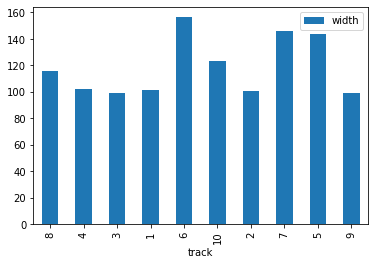

In [12]:
dfmp.plot(y='width',x='track',kind='bar')

Bar plot of melt pool depths

<AxesSubplot:xlabel='track'>

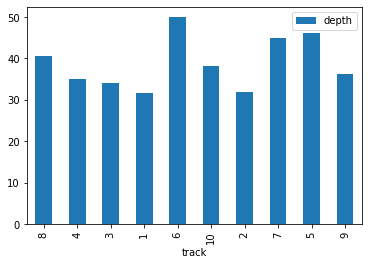

In [13]:
dfmp.plot(y='depth',x='track',kind='bar')

Example of what the image looks like with the bbox marked

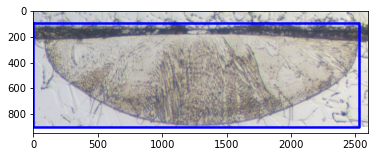

In [14]:
fig, ax = plt.subplots()
minr,minc,maxr,maxc=bboxes[4]
ax.imshow(result[4][900:1800,800:3400])
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()

Putting the calculated measurements into a csv file and saving it

In [15]:
dfmp.to_csv('MP_measurements.csv',index=False)